In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
import os


In [2]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Your code here


In [3]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\juan-\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# Load the CSV file
df = pd.read_csv(
    r'C:\Users\juan-\Documents\Proyecto Hacku AI\Repositorio GitHub página\proyecto_integrador_equipo_27\Avance4.27\GloVE\HS code Catalogue_Processed (web scrapped).csv',
    dtype={'HTS code': str}  # Specify the column to be read as string
)
# Rename columns for easier access
df.rename(columns={'HS Code': 'HTS_code', 'Full description': 'Description'}, inplace=True)

# Preprocess descriptions (remove punctuation, convert to lower case)
df['processed_description'] = df['Description'].str.replace(r'[^\w\s]', '', regex=True).str.lower()

# Handle NaN values
df = df.dropna(subset=['HTS_code', 'processed_description'])

# Convert HTS_code to string and remove periods
df['HTS_code'] = df['HTS_code'].str.replace('.', '', regex=False)

# Trim HTS codes to the leftmost 6 characters and pad with trailing zeros if shorter
df['HTS_code'] = df['HTS_code'].apply(lambda x: x[:6].ljust(6, '0'))

# Create a text file for unsupervised training, where each line is a processed description
unsupervised_file_path = 'unsupervised_training_data.txt'
df['processed_description'].to_csv(unsupervised_file_path, index=False, header=False)

df.head(100)

,HTS_code,Description,processed_description
0,010000,Chapter 1 Live animals,chapter 1 live animals
1,010100,"Live horses, asses, mules and hinnies.",live horses asses mules and hinnies
2,010121,"Live horses, asses, mules and hinnies. - > Hor...",live horses asses mules and hinnies horses ...
3,010129,"Live horses, asses, mules and hinnies. - > Hor...",live horses asses mules and hinnies horses ...
4,010130,"Live horses, asses, mules and hinnies. -> Asses:",live horses asses mules and hinnies asses
...,...,...,...
95,020500,"Meat of horses, asses, mules or hinnies, fresh...",meat of horses asses mules or hinnies fresh ch...
96,020600,"Edible offal of bovine animals, swine, sheep, ...",edible offal of bovine animals swine sheep goa...
97,020610,"Edible offal of bovine animals, swine, sheep, ...",edible offal of bovine animals swine sheep goa...
98,020621,"Edible offal of bovine animals, swine, sheep, ...",edible offal of bovine animals swine sheep goa...


In [5]:
import numpy as np

# Load GloVe embeddings
def load_glove_embeddings(file_path):
    glove_embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            embedding = np.array(values[1:], dtype='float32')
            glove_embeddings[word] = embedding
    return glove_embeddings

# Specify the path to your GloVe file
glove_file_path = r'C:\Users\juan-\Documents\Proyecto Hacku AI\Repositorio GitHub página\proyecto_integrador_equipo_27\Avance4.27\GloVE\glove.6B.100d.txt'
glove_embeddings = load_glove_embeddings(glove_file_path)


In [6]:
def vectorize_description(description, glove_embeddings):
    words = description.split()
    word_vectors = [glove_embeddings[word] for word in words if word in glove_embeddings]
    if not word_vectors:
        return np.zeros(100)  # Return a zero vector if no words are found
    return np.mean(word_vectors, axis=0)

# Vectorize each description in the DataFrame
df['description_vector'] = df['processed_description'].apply(lambda x: vectorize_description(x, glove_embeddings))


In [7]:
from sklearn.metrics.pairwise import cosine_similarity

def predict_hs_code(input_description, df, glove_embeddings):
    input_vector = vectorize_description(input_description, glove_embeddings)
    
    # Calculate cosine similarities between the input vector and all description vectors
    similarities = cosine_similarity([input_vector], list(df['description_vector']))
    
    # Get the index of the most similar description
    most_similar_index = np.argmax(similarities)
    
    # Return the corresponding HTS code
    return df.iloc[most_similar_index]['HTS_code']

In [8]:
# Example usage
input_desc = "furniture"
predicted_code = predict_hs_code(input_desc, df, glove_embeddings)
print(f"Predicted HTS Code: {predicted_code}")

Predicted HTS Code: 940360


In [9]:
validation_df = pd.read_csv(
    r'C:\Users\juan-\Documents\Proyecto Hacku AI\Repositorio GitHub página\proyecto_integrador_equipo_27\Avance4.27\GloVE\data validation verified.csv',
    dtype={'HTS code': str}  # Specify the column to be read as string
)

validation_df

,Raw_data_input,Raw_data_input_processed,LLM_prediction,Expected_output,Expected_output_two_digits,Expected_output_four_digits
0,CERAMIC TABLEWARE 26 PALL ETS 192 BOXES 2688 B...,ceramic tableware pall ets box boxe,6910,6912,69,6912
1,TOTAL 5040 BOXES ONLY TOTA L FIVE THOUSAND FOU...,total box tota l five thousand fourty box tota...,6915,6907210,69,6907
2,FREE-CUTTING STEELS COLD DRAWN SPECIFICATION C...,freecutting steel cold drawn specification clc,7213,72151000,72,7215
3,PAPER FOR CORES K 05 HS CODE48239085 NCM CODES...,paper core,4811.10.00,48239085,48,4823
4,CIGARETTES SO 10217102461021742687 HS CODE 240...,cigarette,2401,2402,24,2402
...,...,...,...,...,...,...
215,SHOWCAR 1999 FERRARI F399 - VIN26 HS CODE8703.23,showcar ferrari vin,8701.10.00,8703,87,8703
216,STEEL BARS HS CODE 72283061 NCM CODES 72283061,steel bar,7213,72283061,72,7228
217,CERAMIC TILES AND SAMPLES HS CODE 690721 18 PA...,ceramic tile sample,6915,690721,69,6907
218,1X20DC. SAID TO CONTAIN 20 PAL TANNING EXTRACT...,said contain pal tanning extract dyeing extrac...,3204,32041610,32,3204


In [10]:
import pandas as pd
from transformers import MarianMTModel, MarianTokenizer, BertTokenizer, BertModel
import nltk
from nltk.corpus import words, stopwords
from nltk.stem import WordNetLemmatizer
import string
import re
import torch
from collections import Counter

# Download necessary NLTK data
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Load the translation model (use Spanish-to-English model)
model_name = 'Helsinki-NLP/opus-mt-es-en'  # Spanish to English model
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

# Load BERT model for attention scoring
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Get the English words corpus and Spanish stopwords
english_words = set(words.words())
spanish_stopwords = set(stopwords.words('spanish'))
english_stopwords = set(stopwords.words('english'))

# Add your custom stopwords to the Spanish stopwords
additional_stopwords = {
    'abv', 'accessories', 'aduana', 'agent', 'ancho', 'approximately', 'approx', 'ata', 'atd', 'attn', 'attention',
    'awb', 'b', 'bag', 'bags', 'barge', 'batch', 'big', 'bill', 'bl', 'bol', 'bonded', 'bottle', 'bottles',
    'box', 'boxes', 'broker', 'bulk', 'bundle', 'bundles', 'cargo', 'carrier', 'carton', 'cartons', 'case', 'cases',
    'cb', 'cbm', 'celsius', 'center', 'certificate', 'certification', 'cfr', 'charge', 'charges', 'cif', 'cip', 'circa',
    'claim', 'class', 'classification', 'clearance', 'cl', 'closing', 'cm', 'cmr', 'cntr', 'code', 'codes', 'collect',
    'collection', 'commercial', 'commodity', 'consolidated', 'consolidator', 'consignee', 'consignor', 'contain',
    'container', 'containers', 'containing', 'contains', 'contact', 'coo', 'cross', 'ctr', 'ctpat', 'cube', 'cubic',
    'customs', 'cut-off', 'damage', 'dangerous', 'dap', 'date', 'dated', 'dc', 'ddp', 'deadline', 'declared',
    'declares', 'declaration', 'degr', 'degrees', 'delay', 'delivery', 'demurrage', 'description', 'destination',
    'detention', 'dg', 'diameter', 'dim', 'dimension', 'dimensions', 'discharge', 'distribution', 'dock',
    'documentation', 'dt', 'dtd', 'duty', 'each', 'eccn', 'email', 'entry', 'eta', 'etd', 'event', 'exception',
    'excise', 'export', 'exportation', 'exw', 'fas', 'fax', 'fcl', 'feeder', 'fees', 'feu', 'flat', 'flight', 'fob',
    'forwarder', 'free', 'freight', 'gp', 'gross', 'gst', 'handling', 'hazardous', 'hbl', 'hc', 'height', 'high',
    'hr', 'hs', 'hs-code', 'hscode', 'hts', 'id', 'imdg', 'imo', 'import', 'importation', 'impression', 'impresion',
    'incoterms', 'inch', 'inches', 'inspection', 'insurance', 'intermodal', 'inv', 'invoice', 'invoices', 'iso',
    'item', 'items', 'iva', 'jumbo', 'kg', 'kgs', 'lading', 'largo', 'lcl', 'length', 'license', 'load', 'loaded',
    'loading', 'logistics', 'loose', 'loss', 'lot', 'lote', 'm3', 'manifest', 'marks', 'mbl', 'measurement',
    'measurements', 'medium', 'meter', 'metric', 'milestone', 'mm', 'mode', 'mt', 'multimodal', 'ncm', 'net',
    'netweight', 'no', 'non-hazardous', 'non-stackable', 'note', 'notes', 'notify', 'number', 'numbers', 'nvocc',
    'of', 'only', 'open', 'order', 'origin', 'packaging', 'packing', 'pallet', 'pallets', 'palletized', 'party',
    'payable', 'pc', 'pcs', 'permit', 'phytosanitary', 'pickup', 'piece', 'pieces', 'pkg', 'pkgs', 'pl', 'plt',
    'plts', 'po', 'port', 'prepaid', 'qty', 'quantity', 'quota', 'rack', 'rail', 'reefer', 'reel', 'reels', 'ref',
    'reference', 'report', 'restriction', 'rfc', 'roll', 'rolls', 'routing', 'sack', 'sacks', 'said', 'sailing',
    'scac', 'schedule', 'seal', 'seals', 'serial', 'sheets', 'shipment', 'shipper', 'shipping', 'sin', 'size',
    'sizes', 'small', 'stackable', 'status', 'stc', 'storage', 'stowed', 'stuffing', 'surcharges', 'survey',
    'system', 'tank', 'tare', 'tariff', 'tax', 'temperature', 'temp', 'terminal', 'teu', 'time', 'to', 'ton',
    'tons', 'top', 'total', 'tracking', 'tracing', 'trade', 'transit', 'transload', 'transhipment', 'transport',
    'truck', 'un', 'unit', 'unstuffing', 'valuation', 'value', 'vat', 'vessel', 'volume', 'voyage', 'warehouse',
    'weight', 'width', 'x', 'zone'
}


stop_words = spanish_stopwords.union(additional_stopwords)
stop_words = stop_words.union(english_stopwords)

# Function to preprocess text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text.strip()

# Function to translate text to English
def translate_to_english(text, tokenizer, model):
    translated = model.generate(**tokenizer.prepare_seq2seq_batch([text], return_tensors="pt"))
    return tokenizer.decode(translated[0], skip_special_tokens=True)

# Function to lemmatize, remove nonsense words, and clean text
def lemmatize_and_clean(text):
    words = text.split()
    cleaned_words = []
    for word in words:
        lemma = lemmatizer.lemmatize(word)
        if lemma in english_words and lemma not in stop_words:
            cleaned_words.append(lemma)
    return cleaned_words  # Return list of cleaned words

# Function to get top tokens based on frequency and attention scores
def get_top_tokens(text, top_n=3):
    inputs = bert_tokenizer(text, return_tensors='pt')
    outputs = bert_model(**inputs)
    
    # Get the attention scores (mean pooling over token embeddings)
    attention_scores = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
    
    # Create a dictionary of tokens and their corresponding attention scores
    tokens_with_scores = {token_id: score for token_id, score in zip(inputs['input_ids'][0], attention_scores)}
    
    # Filter out special tokens and get full tokens without subword prefixes
    filtered_tokens_scores = {}
    
    for token_id, score in tokens_with_scores.items():
        if token_id not in [bert_tokenizer.pad_token_id, bert_tokenizer.cls_token_id, bert_tokenizer.sep_token_id]:
            token_str = bert_tokenizer.decode([token_id]).replace("##", "")
            filtered_tokens_scores[token_str] = score
    
    # Count occurrences of each token in the cleaned words list for additional scoring
    word_counts = Counter(lemmatize_and_clean(text))
    
    # Combine frequency counts with attention scores for final ranking
    combined_scores = {token: word_counts[token] + filtered_tokens_scores.get(token, 0) for token in filtered_tokens_scores}
    
    # Sort by combined score and get top N tokens
    top_tokens = sorted(combined_scores.items(), key=lambda item: item[1], reverse=True)[:top_n]
    
    return [token for token, _ in top_tokens]

# Full pipeline function
def process_text(text, type):
    try:
        # Step 1: Preprocess
        preprocessed_text = preprocess_text(text)
        
        # Step 2: Translate
        translated_text = translate_to_english(preprocessed_text, tokenizer, model)
        
        # Step 3: Lemmatize, remove nonsense words, and clean
        cleaned_words_list = lemmatize_and_clean(translated_text)
        
        # Convert cleaned words list back to string for attention scoring
        final_cleaned_text = " ".join(cleaned_words_list)

        # Step 4: Get top tokens based on frequency and attention scores
        top_tokens = get_top_tokens(final_cleaned_text)

        # Return based on the type parameter
        if type == 1:
            return final_cleaned_text
        else:
            return top_tokens
        
    except Exception as e:
        print(f"An error occurred: {e}")
        return ""

    except Exception as e:
        print(f"Error processing text: {text}")
        print(f"Error message: {str(e)}")
        return "", []  # Return empty string and empty list in case of error

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\juan-\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juan-\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\juan-\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\juan-\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected

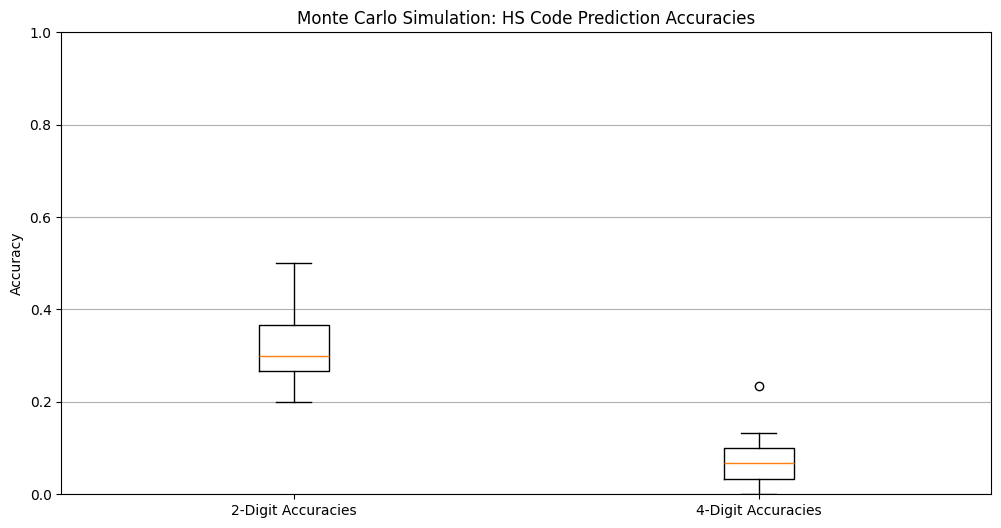

[0.26666666666666666, 0.3333333333333333, 0.3, 0.26666666666666666, 0.3333333333333333, 0.43333333333333335, 0.4, 0.43333333333333335, 0.26666666666666666, 0.26666666666666666, 0.23333333333333334, 0.3333333333333333, 0.2, 0.36666666666666664, 0.5, 0.23333333333333334, 0.26666666666666666, 0.36666666666666664, 0.3, 0.3]
[0.0, 0.06666666666666667, 0.03333333333333333, 0.03333333333333333, 0.1, 0.23333333333333334, 0.1, 0.03333333333333333, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.03333333333333333, 0.0, 0.0, 0.13333333333333333, 0.03333333333333333, 0.13333333333333333, 0.0, 0.1, 0.06666666666666667]


In [11]:
# Function to simulate Monte Carlo runs

two_digit_accuracies = []
four_digit_accuracies = []

def monte_carlo_simulation(validation_data, df, glove_embeddings, num_runs=20):


    for run in range(num_runs):
        # Generate 30 random indices from the validation set
        random_indices = np.random.choice(validation_data.index, size=30, replace=False)
        
        correct_two_digits = 0
        correct_four_digits = 0

        for idx in random_indices:
            validation_input = validation_data.loc[idx, 'Raw_data_input']
            expected_two_digits = validation_data.loc[idx, 'Expected_output_two_digits']
            expected_four_digits = validation_data.loc[idx, 'Expected_output_four_digits']

            # Check if validation_input is a valid string
            if isinstance(validation_input, str):
                # Run prediction function with the original df
                predicted_code = predict_hs_code(process_text(validation_input,1), df, glove_embeddings)

                # Log the index, expected, predicted values, and the input description
                #print(f"Run {run + 1}, Index: {idx}, Input Description: '{validation_input}', "
                      #f"Expected 2-Digit: {expected_two_digits}, Predicted: {predicted_code[:2]}, "
                      #f"Expected 4-Digit: {expected_four_digits}, Predicted: {predicted_code}")
                
                #print(predicted_code[:2])
                #print(predicted_code[:4])
                #print(expected_two_digits)
                #print(expected_four_digits)

                # Check accuracy for 2-digit and 4-digit codes
                if str(predicted_code[:2]) == str(expected_two_digits).strip():
                    correct_two_digits += 1
                    #print(correct_two_digits)

                if str(predicted_code[:4]) == str(expected_four_digits).strip():
                    correct_four_digits += 1
                    #print(correct_four_digits)
            else:
                print(f"Warning: Invalid input for index {idx}: {validation_input}")

        # Calculate accuracies

        
        two_digit_accuracy = correct_two_digits / 30
        four_digit_accuracy = correct_four_digits / 30

        two_digit_accuracies.append(two_digit_accuracy)
        four_digit_accuracies.append(four_digit_accuracy)

    return two_digit_accuracies, four_digit_accuracies

# Assuming df is your original DataFrame with all the necessary data
# Assuming validation_data is your DataFrame specifically for validation
two_digit_accuracies, four_digit_accuracies = monte_carlo_simulation(validation_df, df, glove_embeddings)

# Plot the results
plt.figure(figsize=(12, 6))
plt.boxplot([two_digit_accuracies, four_digit_accuracies], labels=['2-Digit Accuracies', '4-Digit Accuracies'])
plt.title('Monte Carlo Simulation: HS Code Prediction Accuracies')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

print(two_digit_accuracies)
print(four_digit_accuracies)
